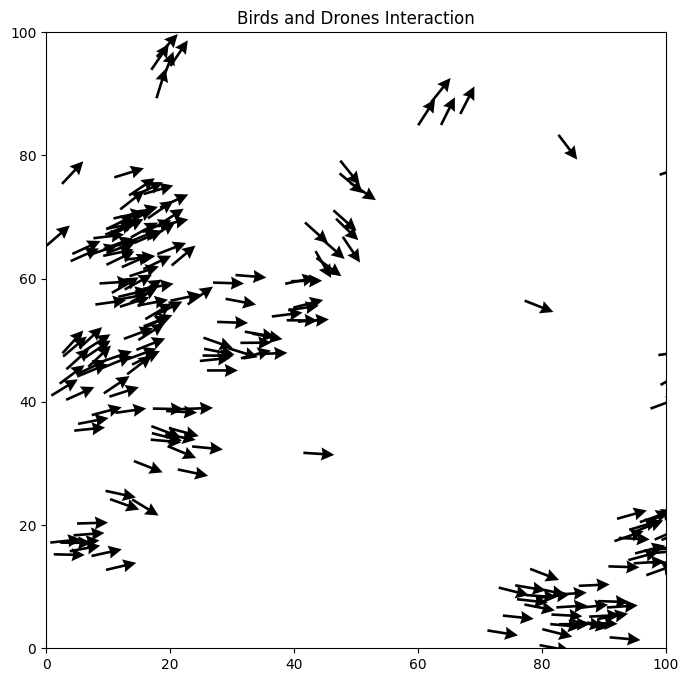

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Parameters for the Vicsek model
N = 200  # number of birds
L = 100  # size of the domain (meters)

eta = 0.5  # noise
v = 10  # velocity of birds (meters per second)
dt = 0.1    # time step  (seconds)
R = 5     # radius of interaction
Nt = 1200  # number of time steps (Total time = Nt * dt)

# Parameters for drones
Nd = 0  # number of drones
vd = 10  # constant speed of drones
Rd = 5  # range of influence of drones
# Additional array to keep track of which drone each bird is following
# -1 indicates that the bird is not following any drone
stuck_birds = set()

flock_sizes = []


# Initialize birds
def initialize_birds(N, L):
    x = np.random.rand(N) * L
    y = np.random.rand(N) * L
    theta = np.random.rand(N) * 2 * np.pi
    vx = v * np.cos(theta)
    vy = v * np.sin(theta)
    return x, y, vx, vy, theta

# Initialize drones
def initialize_drones(Nd, L):
    x = np.random.rand(Nd) * L
    y = np.random.rand(Nd) * L
    theta = np.random.rand(Nd) * 2 * np.pi
    vx = vd * np.cos(theta)
    vy = vd * np.sin(theta)
    return x, y, vx, vy

def update(x, y, vx, vy, theta, drone_x, drone_y, drone_vx, drone_vy, Rsq, eta, N, dt, stuck_birds):
    for i in range(N):
        if i not in stuck_birds:
            # Calculate distance to each drone
            dx = drone_x - x[i]
            dy = drone_y - y[i]
            dist_sq = dx**2 + dy**2

            # Check if any drone is within influence range
            within_range = dist_sq < Rd**2
            if np.any(within_range):
                # Attract birds towards the closest drone and match drone speed
                closest_drone = np.argmin(dist_sq)
                stuck_birds.add(i)  # Mark this bird as 'stuck' to a drone
                vx[i] = drone_vx[closest_drone]
                vy[i] = drone_vy[closest_drone]
            else:
                # Vicsek model update
                within_radius = (x - x[i])**2 + (y - y[i])**2 < Rsq
                theta[i] = np.arctan2(vy[within_radius].mean(), vx[within_radius].mean()) + eta * (np.random.rand() - 0.5)
                vx[i] = v * np.cos(theta[i])
                vy[i] = v * np.sin(theta[i])
        else:
            # If the bird is 'stuck', it keeps moving with its assigned drone's velocity
            closest_drone = np.argmin((drone_x - x[i])**2 + (drone_y - y[i])**2)
            vx[i] = drone_vx[closest_drone]
            vy[i] = drone_vy[closest_drone]

    # Update positions
    x += vx * dt
    y += vy * dt

    # Apply periodic boundary conditions
    x = x % L
    y = y % L

    return x, y, vx, vy, stuck_birds


def update_drones(drone_x, drone_y, drone_vx, drone_vy, L, vd, dt):
    # Move drones straight ahead
    drone_x += drone_vx * dt
    drone_y += drone_vy * dt

    # Check for proximity and pass each other without changing direction
    for i in range(Nd):
        for j in range(i + 1, Nd):
            dx = drone_x[i] - drone_x[j]
            dy = drone_y[i] - drone_y[j]
            dist = np.sqrt(dx**2 + dy**2)
            if dist < Rd:  # If drones are too close
                # Adjust their positions slightly to avoid overlap without changing direction
                drone_x[i] += drone_vx[i] * dt
                drone_y[i] += drone_vy[i] * dt
                drone_x[j] += drone_vx[j] * dt
                drone_y[j] += drone_vy[j] * dt

    # Apply periodic boundary conditions
    drone_x = drone_x % L
    drone_y = drone_y % L

    return drone_x, drone_y, drone_vx, drone_vy


def calculate_flock_size(bird_positions, R):
    # If there are no birds, return 0
    if len(bird_positions) == 0:
        return 0
    
    # Initialize a counter for the total number of birds within range
    total_birds_within_range = 0

    # Loop over all pairs of birds
    for i in range(len(bird_positions)):
        for j in range(i+1, len(bird_positions)):
            # Calculate the distance between the two birds
            distance = np.sqrt((bird_positions[i][0] - bird_positions[j][0])**2 + 
                               (bird_positions[i][1] - bird_positions[j][1])**2)
            
            # If the distance is less than or equal to the specified range, increment the counter
            if distance <= R:
                total_birds_within_range += 1

    # Calculate the average number of birds within range
    average_flock_size = total_birds_within_range / len(bird_positions)

    return average_flock_size




# Visualization function
def visualize(x, y, vx, vy, drone_x, drone_y):
    plt.figure(figsize=(8, 8))

    # Plot birds as smaller arrows
    plt.quiver(x, y, vx, vy, color='black', scale=200, headwidth=5, headlength=5)

    # Plot drones as red diamonds
    plt.scatter(drone_x, drone_y, c='red', marker='D', label='Drones')

    plt.xlim(0, L)
    plt.ylim(0, L)
    plt.title("Birds and Drones Interaction")
    #plt.legend()
    plt.show()



# Simulation
x, y, vx, vy, theta = initialize_birds(N, L)
drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

for _ in range(Nt):
    drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, L, vd, dt)
    x, y, vx, vy, stuck_birds = update(x, y, vx, vy, theta, drone_x, drone_y, drone_vx, drone_vy, R**2, eta, N, dt, stuck_birds)
    
    # Calculate the flock size
    flock_size = calculate_flock_size(list(zip(x, y)), R)
    flock_sizes.append(flock_size)
    
    
    
    visualize(x, y, vx, vy, drone_x, drone_y)
    clear_output(wait=True)




In [24]:
def repeated_flock_size_average(trials):

    flock_size_meta_list=[]

    for trial in range(trials):

    # Parameters for the Vicsek model
        N = 200  # number of birds
        L = 100  # size of the domain (meters)

        eta = 0.5  # noise
        v = 10  # velocity of birds (meters per second)
        dt = 0.1    # time step  (seconds)
        R = 5     # radius of interaction
        Nt = 1200  # number of time steps (Total time = Nt * dt) RUN FOR 2 MINUTES

        # Parameters for drones
        Nd = 0  # number of drones
        vd = 10  # constant speed of drones
        Rd = 5  # range of influence of drones
        # Additional array to keep track of which drone each bird is following
        # -1 indicates that the bird is not following any drone
        stuck_birds = set()

        flock_sizes = []

    # Simulation
        x, y, vx, vy, theta = initialize_birds(N, L)
        #drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

        for _ in range(Nt):
            #drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, L, vd, dt)
            x, y, vx, vy, stuck_birds = update(x, y, vx, vy, theta, drone_x, drone_y, drone_vx, drone_vy, R**2, eta, N, dt, stuck_birds)
    
            # Calculate the flock size
            flock_size = calculate_flock_size(list(zip(x, y)), R)
            flock_sizes.append(flock_size)
    
            #visualize(x, y, vx, vy, drone_x, drone_y)
            #clear_output(wait=True)
    
        flock_size_meta_list.append(flock_sizes)

    return(flock_size_meta_list)


In [25]:
### =======================================

### GENERATE DATA FOR REPEATED READINGS

averaged_10_flock_sizes=repeated_flock_size_average(10)

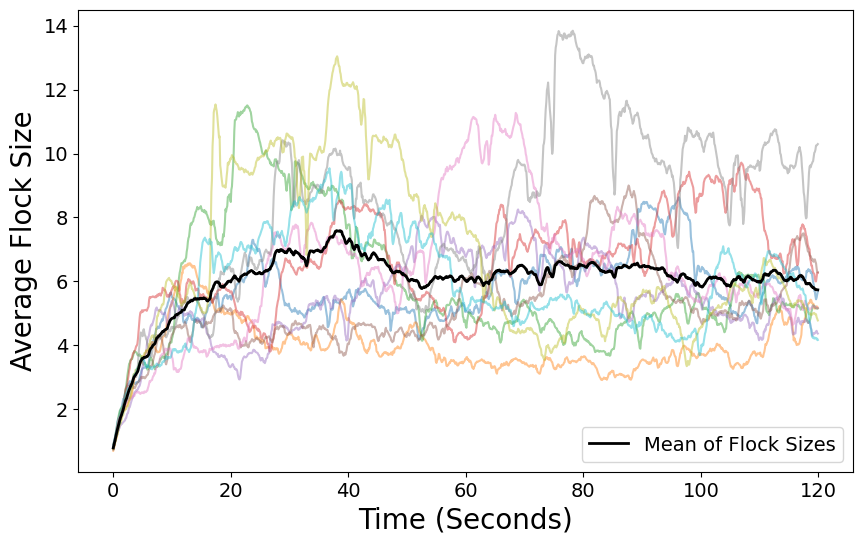

In [79]:
### PLOT REPEATED READINGS

Nt=len(averaged_10_flock_sizes[0])
dt = 0.1

plt.figure(figsize=(10, 6))
for flock_list in averaged_10_flock_sizes:
    plt.plot(np.arange(Nt) * dt, flock_list, alpha=0.45)  # Plot each individual simulation with some transparency

# Calculate the average flock size at each timestep and plot it
average_flock_size = np.mean(averaged_10_flock_sizes, axis=0)
plt.plot(np.arange(Nt) * dt, average_flock_size, color='black', linewidth=2, label='Mean of Flock Sizes')  # Average line

# Label the plot
plt.rcParams.update({'font.size': 14})

plt.xlabel('Time (Seconds)',size=20)
plt.ylabel('Average Flock Size',size=20)
plt.title('')
plt.legend(loc='lower right')

# Show the plot
plt.show()

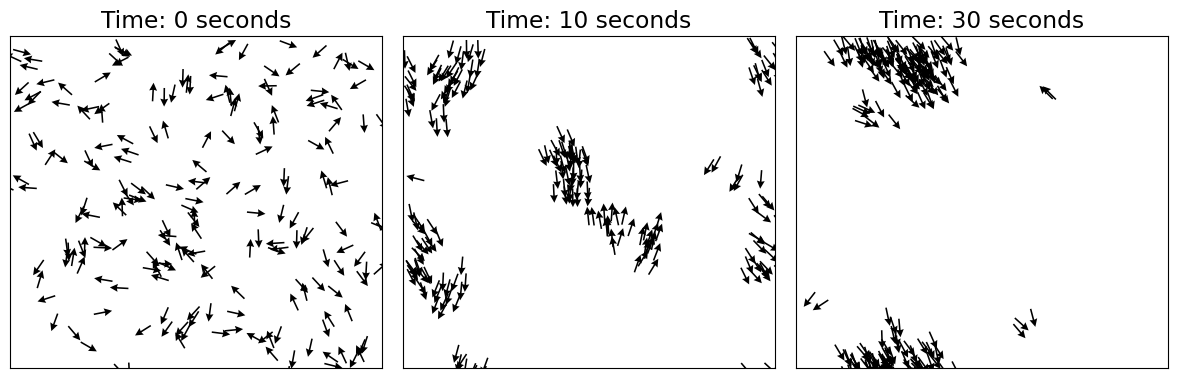

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# ... [your code for the initialize_birds, update, and other functions] ...
Nt=310
# Simulation
x, y, vx, vy, theta = initialize_birds(N, L)

# Times at which to capture frames
capture_times = [0, 10, 30]  # in seconds
capture_steps = [int(t / dt) for t in capture_times]  # Convert to time steps

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)

# Run the simulation and capture frames
for time_step in range(Nt):
    x, y, vx, vy, theta = update(x, y, vx, vy, theta, eta, N, dt, R)

    if time_step in capture_steps:
        # Visualize the current state
        index = capture_steps.index(time_step)
        ax = axes[index]
        ax.quiver(x, y, vx, vy, color='black', scale=200, headwidth=5, headlength=5)
        ax.set_xlim(0, L)
        ax.set_ylim(0, L)
        ax.set_title(f"Time: {capture_times[index]} seconds")
        ax.set_xticks([])  # Remove x ticks
        ax.set_yticks([])  # Remove y ticks

plt.tight_layout()
plt.show()
